In [117]:
PALETTE = {
    "minecraft:air": 0,
    "minecraft:stone": 1,
    "minecraft:cobblestone": 2,
    "minecraft:oak_planks": 3,
    "minecraft:spruce_planks": 4,
    "minecraft:glass": 5,
    "minecraft:oak_log": 6,
    "minecraft:oak_stairs": 7,
    "minecraft:stone_bricks": 8,
    "minecraft:stone_slab": 9,
}

In [118]:
import nbtlib
from nbtlib import tag
import numpy as np
import matplotlib.pyplot as plt
import os

In [119]:
def map_block(block_name):
    if block_name in PALETTE:
        return PALETTE[block_name]
    else:
        return PALETTE["minecraft:stone"]

In [120]:
def schem_to_tensor(path, size=16):
    """
    Load a .schem or .schematic file and convert it to a size^3 voxel tensor.
    Unknown blocks → stone
    """
    schem = nbtlib.load(path)

    # Find the correct root key or access pattern
    if hasattr(schem, 'root') and isinstance(schem.root, dict):
        data = schem.root
    elif isinstance(schem, dict):
        data = schem
    elif '' in schem:
        data = schem['']
    elif 'Schematic' in schem:
        data = schem['Schematic']
    else:
        raise ValueError("Could not find schematic data root.")

    # If 'Schematic' is a key at root, use its value as data
    if 'Schematic' in data:
        data = data['Schematic']
        print(f"Switched to Schematic subkey. Available keys: {list(data.keys())}")
    else:
        print(f"Available keys at root: {list(data.keys())}")

    # Read size
    try:
        width = data['Width']
        height = data['Height']
        length = data['Length']
    except KeyError as e:
        raise KeyError(f"Key {e} not found in schematic data. Available keys: {list(data.keys())}")

    # Read blocks (try 'BlockData', 'BlockStates', then 'Blocks')
    if 'BlockData' in data:
        blocks = data['BlockData']
    elif 'BlockStates' in data:
        blocks = data['BlockStates']
    elif 'Blocks' in data:
        blocks = data['Blocks']
        # If blocks is a Compound, print its keys and try to find block data inside
        if isinstance(blocks, dict):
            print(f"'Blocks' is a Compound. Subkeys: {list(blocks.keys())}")
            # Try common subkeys
            for subkey in ['BlockData', 'BlockStates', 'Data', 'data', 'block_data', 'blockstates']:
                if subkey in blocks:
                    blocks = blocks[subkey]
                    print(f"Using subkey '{subkey}' for block data.")
                    break
            else:
                # Try 'Data' (capital D) as a last resort
                if 'Data' in blocks:
                    blocks = blocks['Data']
                    print("Using subkey 'Data' for block data.")
                else:
                    raise ValueError(f"Could not find block data inside 'Blocks'. Subkeys: {list(blocks.keys())}")
    else:
        raise KeyError(f"No block data found. Tried 'BlockData', 'BlockStates', 'Blocks'. Available keys: {list(data.keys())}")

    # Ensure blocks is a list/array of ints
    if not (hasattr(blocks, '__iter__') and not isinstance(blocks, dict)):
        raise ValueError(f"Blocks data is not a list/array. Type: {type(blocks)}. Preview: {str(blocks)[:100]}")

    # Read palette (optional for old .schematic files)
    palette_nbt = data.get('Palette', None)
    if palette_nbt:
        palette_list = [None] * len(palette_nbt)
        for key, val in palette_nbt.items():
            palette_list[val] = key
    else:
        # For old .schematic, just use block IDs as-is
        palette_list = None

    # Create tensor (size x size x size)
    tensor = np.zeros((size, size, size), dtype=np.int64)

    # Compute scaling factors
    scale_x = width / size
    scale_y = height / size
    scale_z = length / size

    # Fill tensor with mapped block values
    for i, block_index in enumerate(blocks):
        # Convert linear index i → x, y, z
        x = i % width
        y = (i // (width * length)) % height
        z = (i // width) % length

        # Scale coordinates to fixed size
        xs = int(x / scale_x)
        ys = int(y / scale_y)
        zs = int(z / scale_z)

        # Get block name and map to palette
        if palette_list:
            block_name = palette_list[block_index]
            tensor[xs, ys, zs] = map_block(block_name)
        else:
            # For old .schematic, just use block_index (block ID) if it's an int
            if isinstance(block_index, int):
                tensor[xs, ys, zs] = block_index
            else:
                raise ValueError(f"Block index is not an int: {block_index} (type: {type(block_index)})")

    return tensor

In [121]:
def show_slice(tensor, y):
    """
    Show a 2D slice of the voxel grid at height y
    """
    plt.figure(figsize=(6,6))
    plt.imshow(tensor[:, y, :], cmap='tab20')
    plt.title(f"Y={y} slice")
    plt.colorbar()
    plt.show()


Switched to Schematic subkey. Available keys: ['Offset', 'DataVersion', 'Length', 'Version', 'Blocks', 'Width', 'Entities', 'Height', 'Metadata']
'Blocks' is a Compound. Subkeys: ['Palette', 'Data', 'BlockEntities']
Using subkey 'Data' for block data.


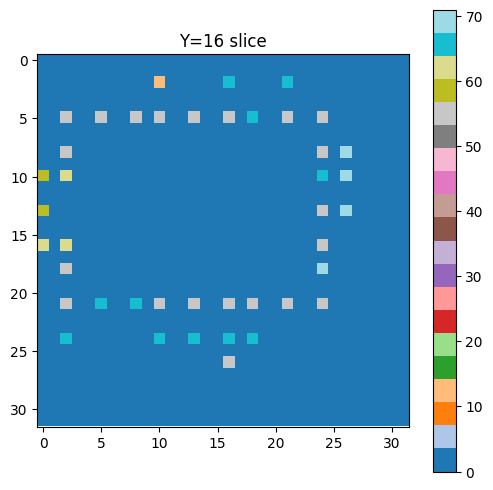

In [122]:
tensor = schem_to_tensor("dataset/rustic-house.schem", size=32)
show_slice(tensor, y=16)  # show middle slice

In [123]:
def process_all_schematics(folder_path, size=16):
    tensors = []
    file_names = []

    for file in os.listdir(folder_path):
        if file.endswith(".schem"):
            path = os.path.join(folder_path, file)
            try:
                tensor = schem_to_tensor(path, size=size)
                tensors.append(tensor)
                file_names.append(file)
                print(f"[+] Processed: {file}")
            except Exception as e:
                print(f"[!] Failed to process {file}: {e}")

    return tensors, file_names

In [124]:
folder = "dataset"
all_tensors, names = process_all_schematics(folder, size=32)
print(f"Processed {len(all_tensors)} schematics.")

Available keys at root: ['Width', 'Height', 'Length', 'PaletteMax', 'Palette', 'BlockData', 'BlockEntities', 'Offset', 'Metadata', 'DataVersion', 'Version']
[+] Processed: example.schem
Switched to Schematic subkey. Available keys: ['Length', 'Width', 'Blocks', 'Offset', 'Version', 'Metadata', 'DataVersion', 'Entities', 'Height']
'Blocks' is a Compound. Subkeys: ['BlockEntities', 'Palette', 'Data']
Using subkey 'Data' for block data.
[+] Processed: house-2.schem
Available keys at root: ['Width', 'Height', 'Length', 'PaletteMax', 'Palette', 'BlockData', 'BlockEntities', 'Offset', 'Metadata', 'DataVersion', 'Version']
[+] Processed: house.schem
Switched to Schematic subkey. Available keys: ['Entities', 'Version', 'Metadata', 'Length', 'Height', 'Blocks', 'Offset', 'Width', 'DataVersion']
'Blocks' is a Compound. Subkeys: ['BlockEntities', 'Data', 'Palette']
Using subkey 'Data' for block data.
[+] Processed: rustic-greenhouse.schem
Switched to Schematic subkey. Available keys: ['Offset', '

In [125]:
import torch
import torch.nn as nn
import torch.optim as optim

In [126]:

# Stack your tensors into a numpy array and convert to torch tensor
X = np.stack(all_tensors)  # shape: (num_samples, 32, 32, 32)
X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # add channel dim: (N, 1, 32, 32, 32)

# Simple 3D CNN Autoencoder
class VoxelAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 16, 3, stride=2, padding=1),  # (N,16,16,16,16)
            nn.ReLU(),
            nn.Conv3d(16, 32, 3, stride=2, padding=1), # (N,32,8,8,8)
            nn.ReLU(),
            nn.Conv3d(32, 64, 3, stride=2, padding=1), # (N,64,4,4,4)
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(64, 32, 3, stride=2, padding=1, output_padding=1), # (N,32,8,8,8)
            nn.ReLU(),
            nn.ConvTranspose3d(32, 16, 3, stride=2, padding=1, output_padding=1), # (N,16,16,16,16)
            nn.ReLU(),
            nn.ConvTranspose3d(16, 1, 3, stride=2, padding=1, output_padding=1),  # (N,1,32,32,32)
            nn.Sigmoid(),  # Output in [0,1]
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [127]:

# Instantiate model, loss, optimizer
model = VoxelAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop (simple, 10 epochs)
for epoch in range(10):
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, X)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# To generate: sample a latent vector and decode
with torch.no_grad():
    z = torch.randn(1, 64, 4, 4, 4)  # random latent
    generated = model.decoder(z)
    generated = generated.squeeze().numpy()  # shape: (32,32,32)

Epoch 1, Loss: 25.7308
Epoch 2, Loss: 25.7280
Epoch 3, Loss: 25.7224
Epoch 4, Loss: 25.7103
Epoch 5, Loss: 25.6875
Epoch 6, Loss: 25.6547
Epoch 7, Loss: 25.6187
Epoch 8, Loss: 25.5884
Epoch 9, Loss: 25.5614
Epoch 10, Loss: 25.5339


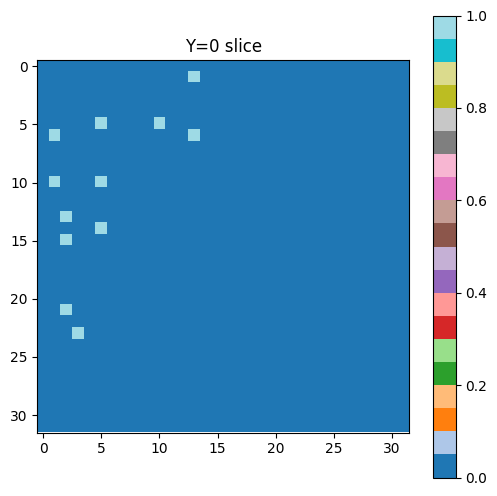

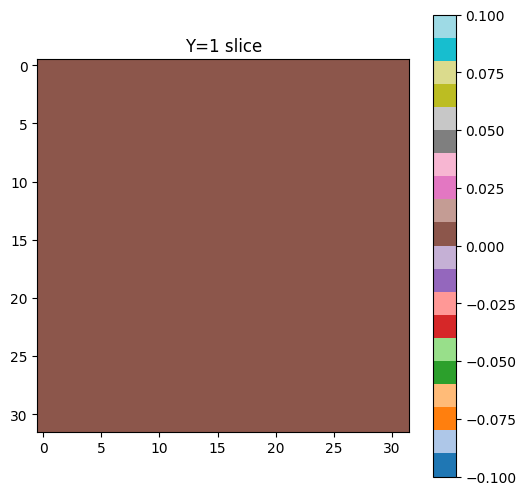

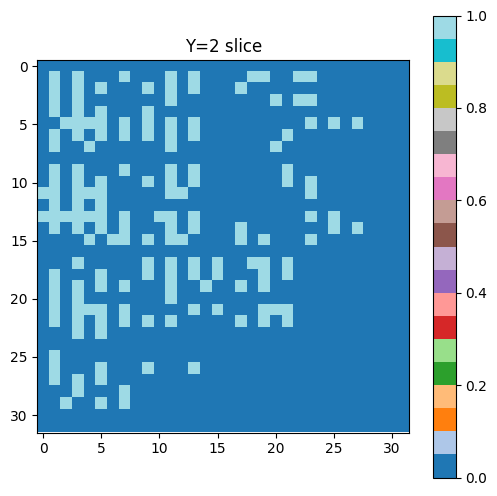

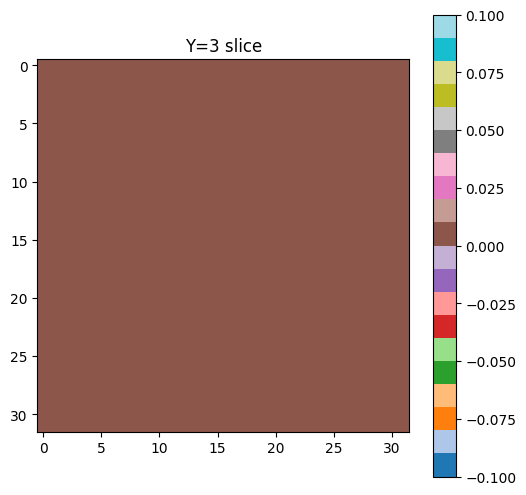

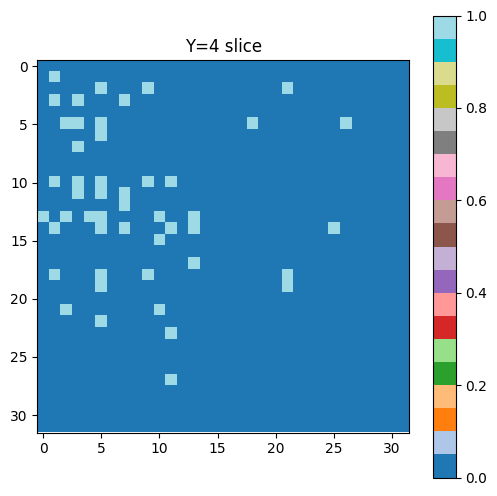

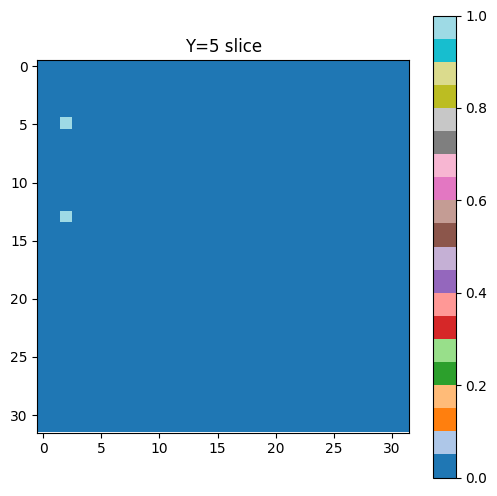

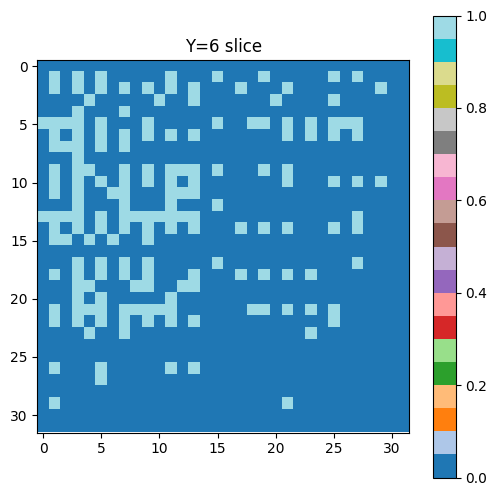

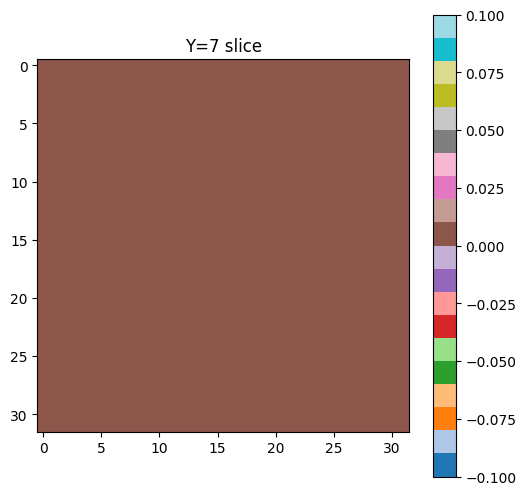

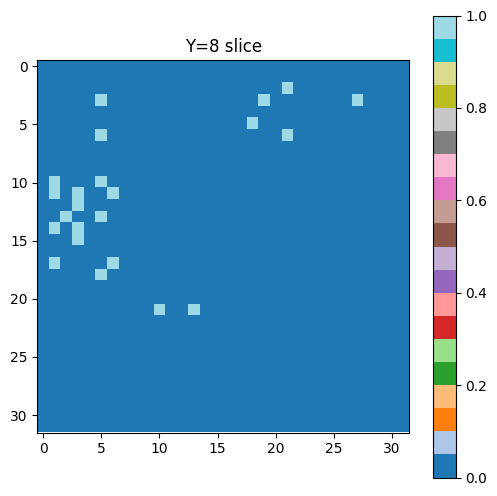

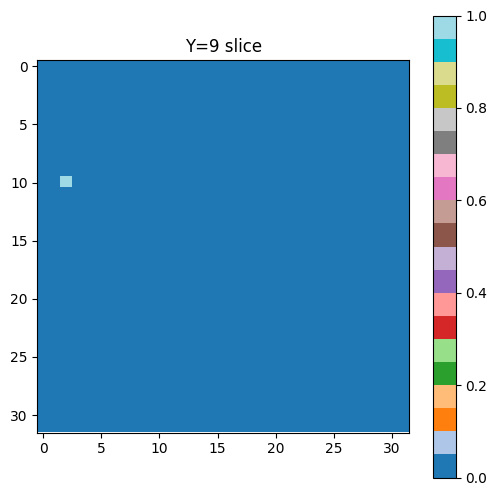

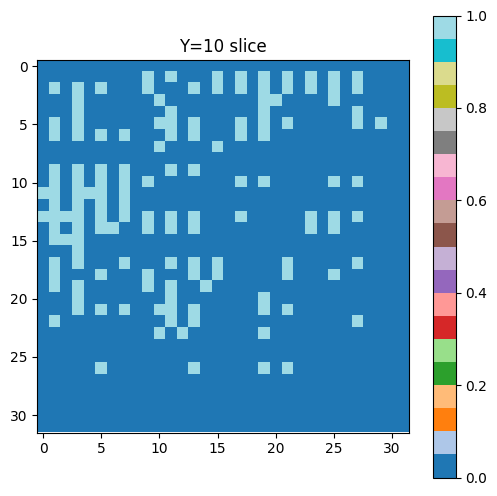

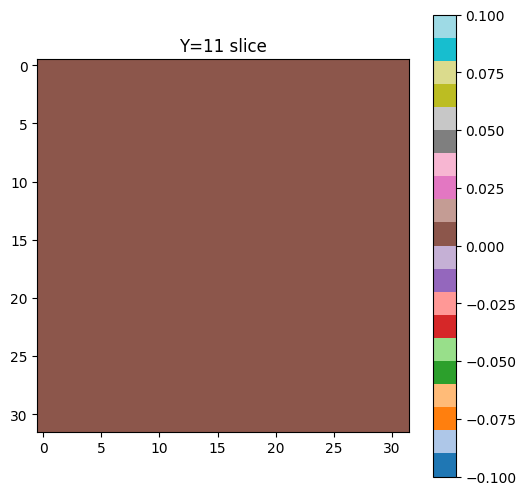

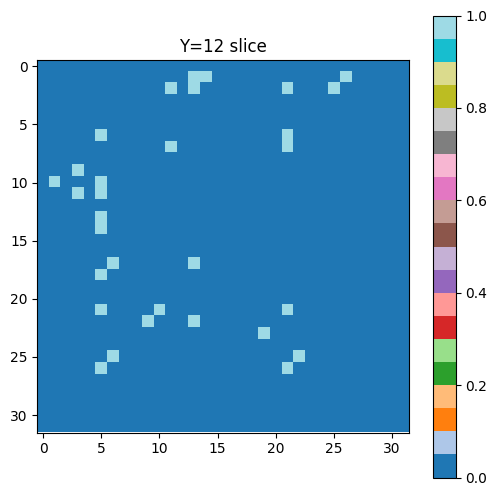

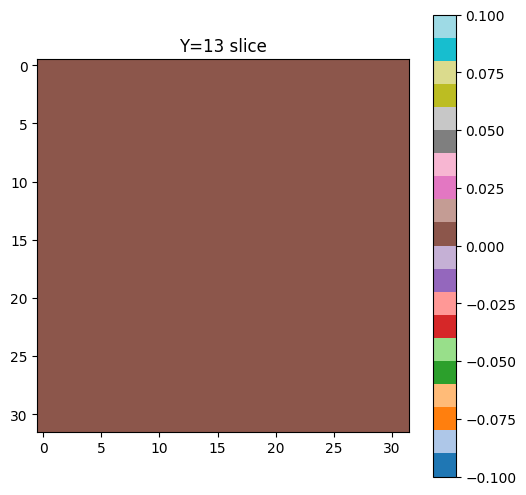

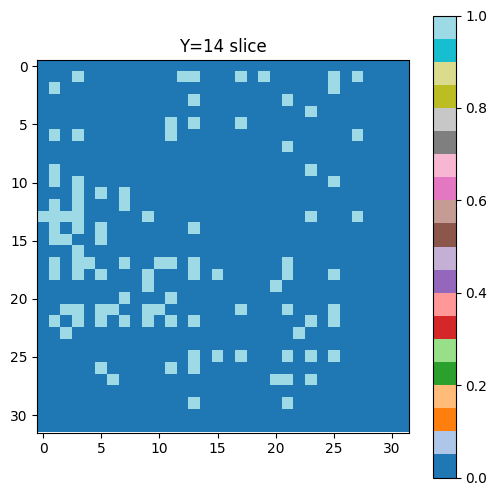

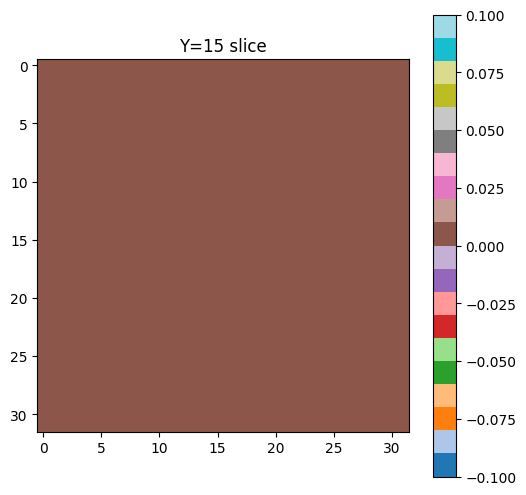

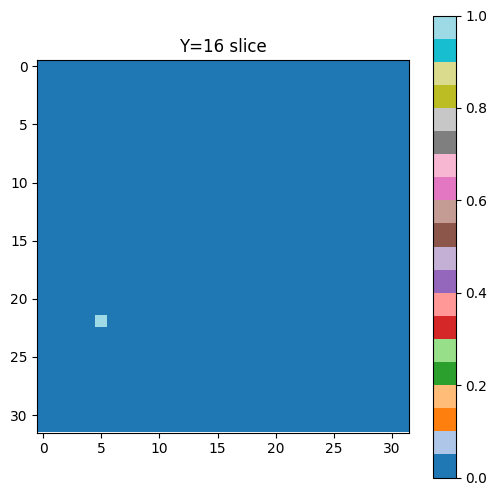

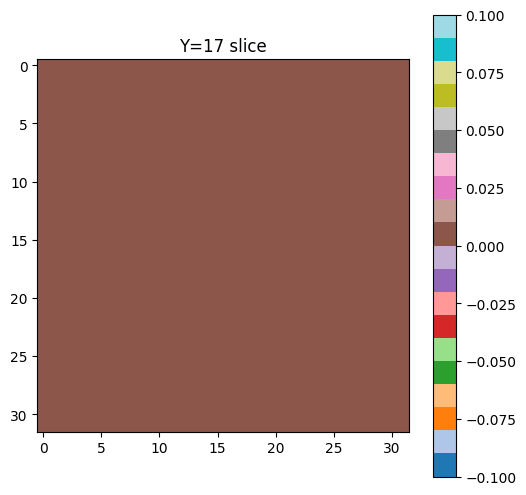

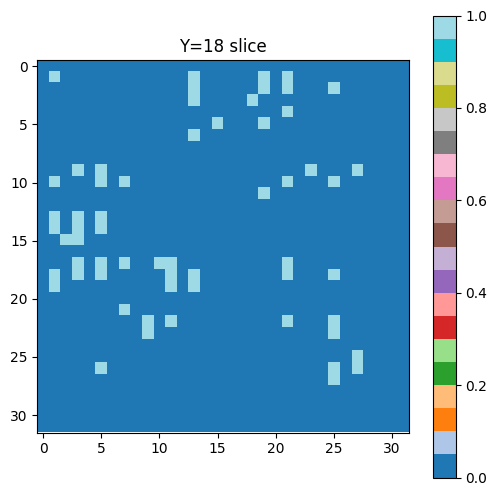

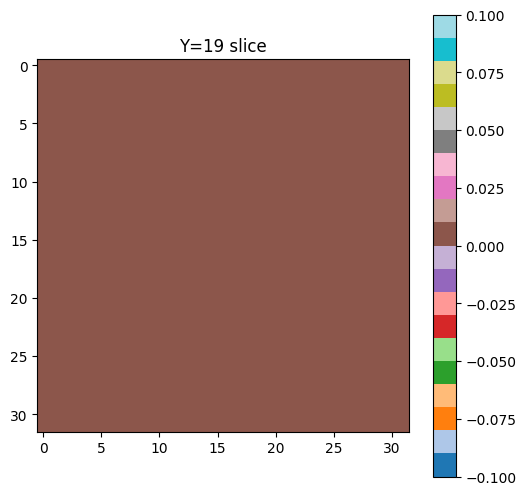

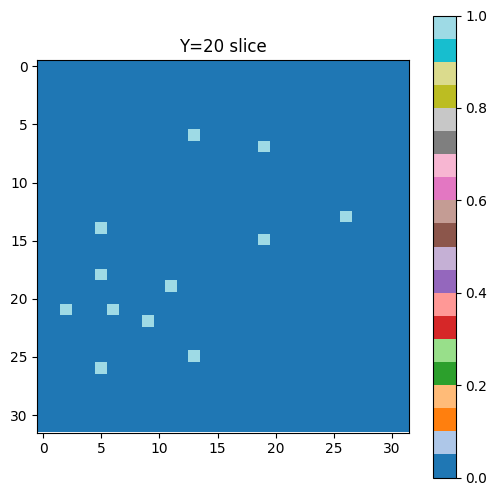

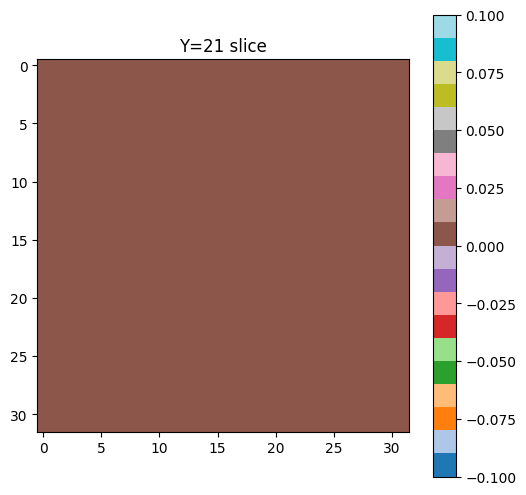

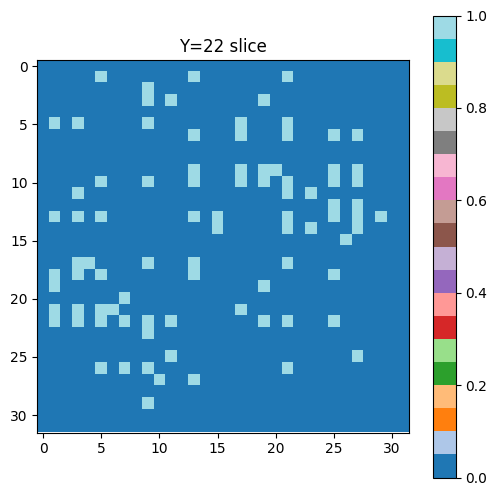

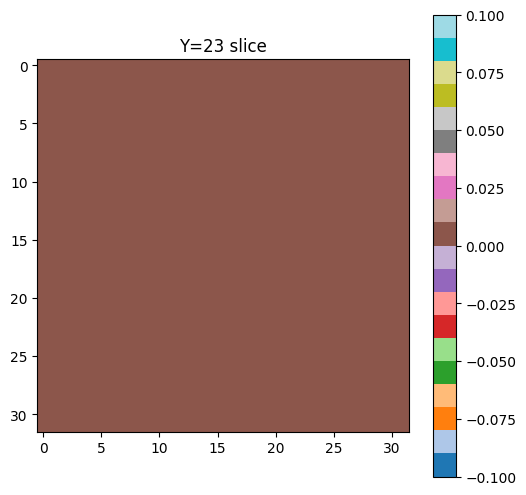

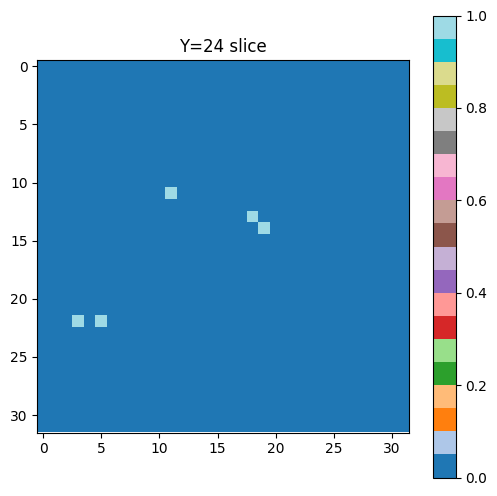

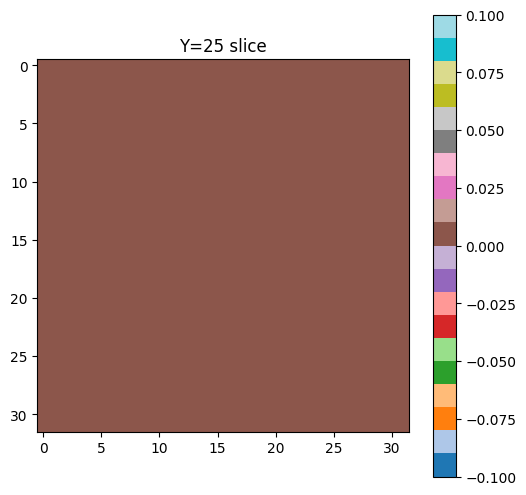

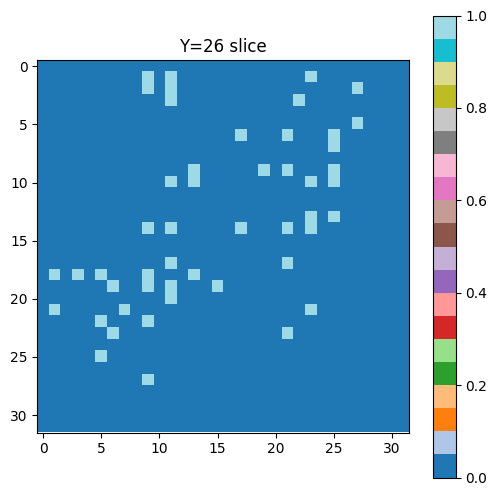

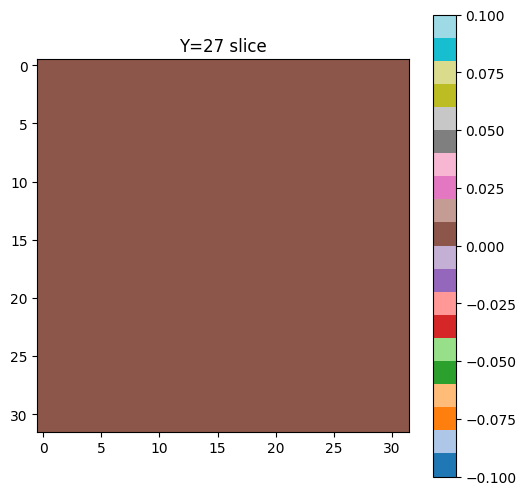

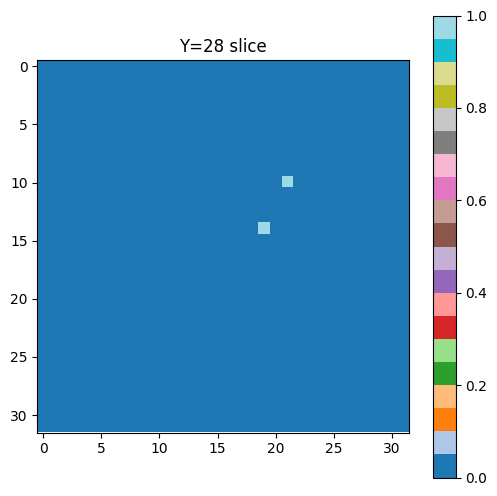

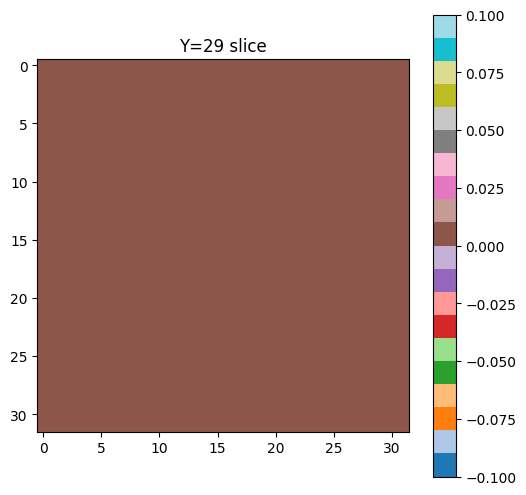

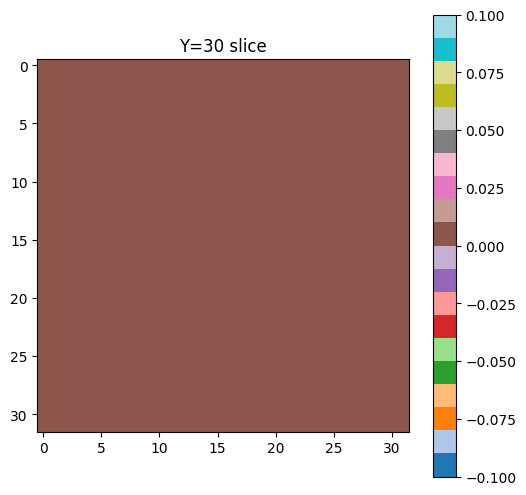

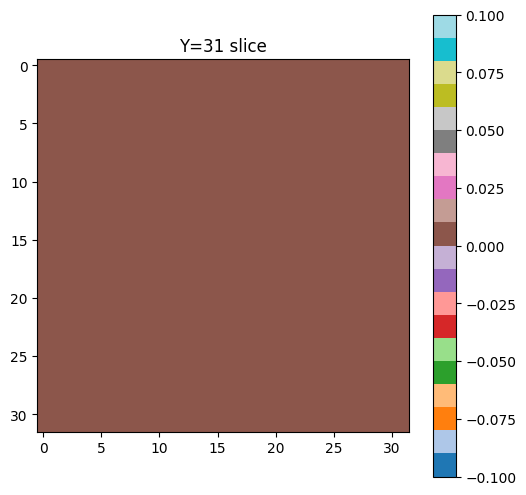

In [128]:
# Sanitize generated output for visualization/export
min_id = min(PALETTE.values())
max_id = max(PALETTE.values())
valid_ids = set(PALETTE.values())

generated_int = np.round(generated).astype(int)
generated_int = np.clip(generated_int, min_id, max_id)
generated_int[~np.isin(generated_int, list(valid_ids))] = PALETTE["minecraft:air"]

# Visualize every slice
y_size = generated_int.shape[1] if generated_int.ndim == 3 else 32
for y in range(y_size):
    show_slice(generated_int, y)

In [129]:
# Export a numpy tensor to a Sponge Schematic v2 file (example.schem compatible, root fields)
from nbtlib import tag, Compound, File

def tensor_to_schematic(tensor, palette_dict, filename):
    """
    Save a (size, size, size) numpy tensor as a .schem file matching the structure of example.schem.
    All fields are at the root, not nested under 'Schematic'.
    Compatible with modern schematic viewers (e.g., schemat.io).
    """
    size = tensor.shape[0]
    palette_nbt = Compound({block: tag.Int(i) for block, i in palette_dict.items()})
    flat = tensor.flatten()
    block_data = tag.ByteArray([int(x) for x in flat])
    palette_max = max(palette_dict.values())
    root = {
        'Width': tag.Short(size),
        'Height': tag.Short(size),
        'Length': tag.Short(size),
        'PaletteMax': tag.Int(palette_max),
        'Palette': palette_nbt,
        'BlockData': block_data,
        'BlockEntities': tag.List[Compound]([]),
        'Offset': tag.List[tag.Int]([0, 0, 0]),
        'Metadata': Compound({}),
        'DataVersion': tag.Int(2730),
        'Version': tag.Int(2),
    }
    nbt_file = File(root)
    nbt_file.save(filename, gzipped=True)
    print(f"Saved schematic to {filename} (Sponge v2, root fields)")

# Example usage:
tensor_to_schematic(generated_int, PALETTE, "output.schem")

Saved schematic to output.schem (Sponge v2, root fields)


Available keys at root: ['Width', 'Height', 'Length', 'PaletteMax', 'Palette', 'BlockData', 'BlockEntities', 'Offset', 'Metadata', 'DataVersion', 'Version']


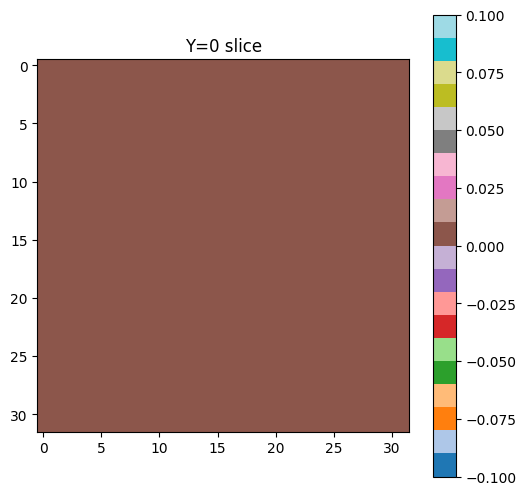

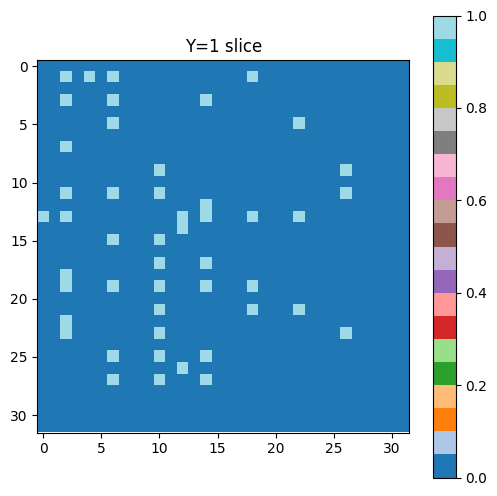

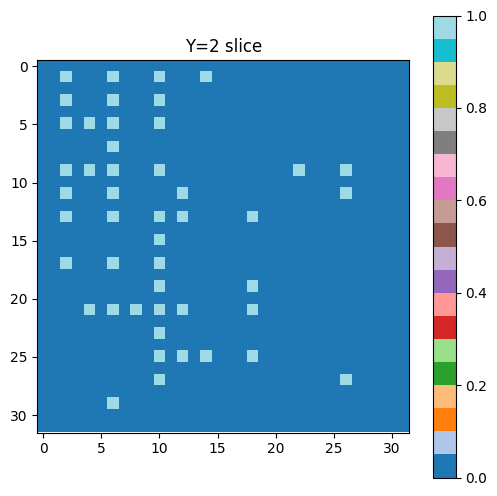

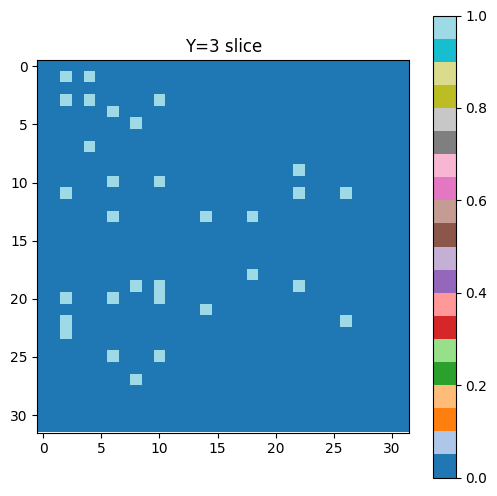

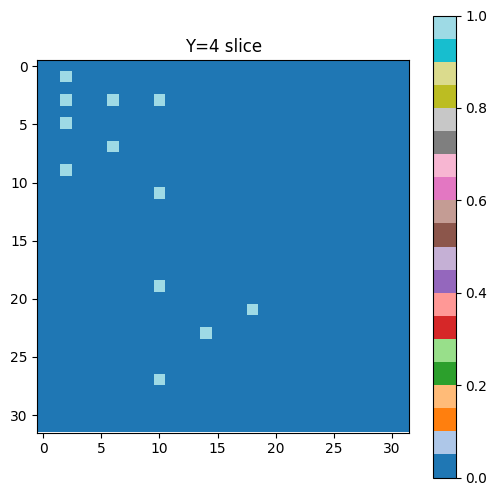

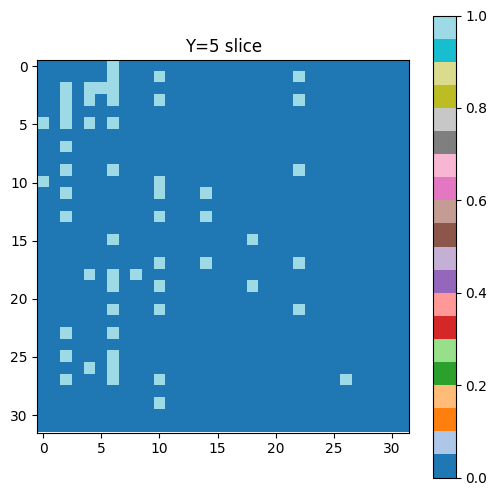

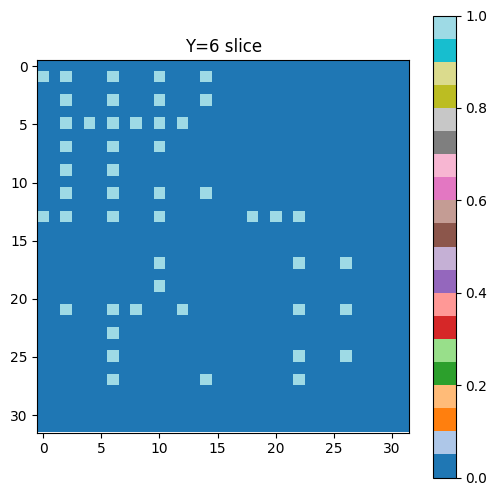

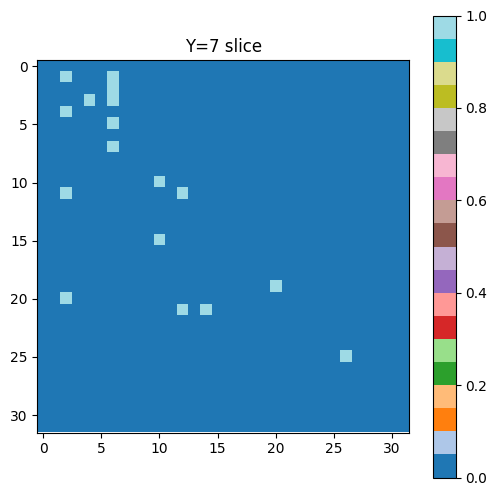

In [130]:
tensor = schem_to_tensor("output.schem", size=32)
for i in range(8):
    show_slice(tensor, y=i)  # show middle slice